# Brain Tumor Images Binary Classification

## Getting the Data from Kaggle

Data was downloaded from [Kaggle](https://www.kaggle.com/ahmedhamada0/brain-tumor-detection) and uploaded it on [drive](https://drive.google.com/file/d/1fWOiE3cQm-chmxn-bq25FRIVAsZFRW_a/view?usp=sharing) for better future access

In [8]:
!nvidia-smi

Tue Feb 15 11:51:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
!gdown --id 1fWOiE3cQm-chmxn-bq25FRIVAsZFRW_a

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1fWOiE3cQm-chmxn-bq25FRIVAsZFRW_a 



In [10]:
from helper_functions import unzip_data, walk_through_dir

In [11]:
unzip_data("Brain_Tumor_Data.zip")

In [12]:
walk_through_dir("Brain_Tumor_Data")

There are 3 directories and 0 images in 'Brain_Tumor_Data'.
There are 0 directories and 1500 images in 'Brain_Tumor_Data/no'.
There are 0 directories and 1500 images in 'Brain_Tumor_Data/yes'.
There are 0 directories and 60 images in 'Brain_Tumor_Data/pred'.


In [13]:
import pathlib
data_dir = pathlib.Path("Brain_Tumor_Data")

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3060

In [15]:
import os
import PIL
import numpy as np

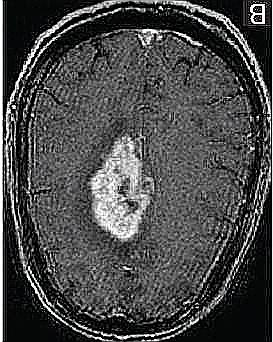

In [16]:
with_tumor = list(data_dir.glob('yes/*'))
PIL.Image.open(with_tumor[0])

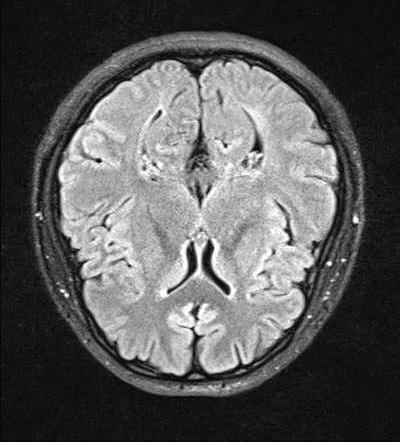

In [17]:
without_tumor = list(data_dir.glob('no/*'))
PIL.Image.open(without_tumor[1])

In [18]:
import tensorflow as tf

In [19]:
list_ds_yes = tf.data.Dataset.list_files(str(data_dir/'yes/*.jpg'),shuffle=False) 
list_ds_no = tf.data.Dataset.list_files(str(data_dir/'no/*.jpg'),shuffle=False) 
list_ds = list_ds_yes.concatenate(list_ds_no)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [20]:
for file in list_ds.take(5):
  
  print(f"{file.numpy()}")

b'Brain_Tumor_Data/yes/y1441.jpg'
b'Brain_Tumor_Data/yes/y1425.jpg'
b'Brain_Tumor_Data/no/no1121.jpg'
b'Brain_Tumor_Data/no/no980.jpg'
b'Brain_Tumor_Data/no/no238.jpg'


In [21]:
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != "pred"])
class_names

array(['no', 'yes'], dtype='<U3')

In [22]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [23]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2388
612


In [24]:
batch_size = 32
img_height = 180
img_width = 180


In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
for image, label in train_ds.take(3):
  print(f"Image shape: {image.numpy().shape}" )
  print(f"Label: {label.numpy()}")

Image shape: (180, 180, 3)
Label: 0
Image shape: (180, 180, 3)
Label: 1
Image shape: (180, 180, 3)
Label: 1


In [30]:
for image, label in val_ds.take(3):
  print(f"Image shape: {image.numpy().shape}" )
  print(f"Label: {label.numpy()}")

Image shape: (180, 180, 3)
Label: 1
Image shape: (180, 180, 3)
Label: 1
Image shape: (180, 180, 3)
Label: 0


In [31]:
def configure_for_performance(ds):
  ds = ds.shuffle(buffer_size = 1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size = tf.data.AUTOTUNE)
  return ds

In [32]:
train_data = configure_for_performance(train_ds)
val_data = configure_for_performance(val_ds)

In [33]:
class_names

array(['no', 'yes'], dtype='<U3')

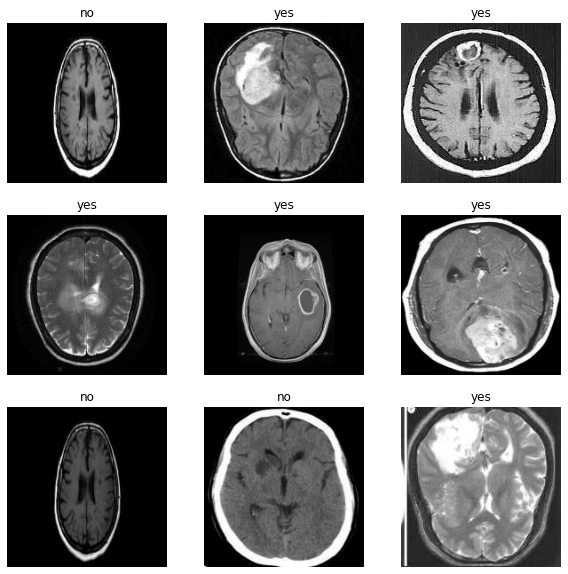

In [34]:
import matplotlib.pyplot as plt

image_batch, label_batch = next(iter(train_data))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  plt.title(class_names[label_batch[i]])
  plt.axis("off")

## Building Model

In [35]:
from tensorflow.keras import layers

In [36]:

model = tf.keras.Sequential([
                             
        # layers.Rescaling(1./255),

        layers.Conv2D(filters = 32, 
                      kernel_size=(3,3), 
                      activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters = 32, 
                      kernel_size=(3,3), 
                      kernel_initializer = "he_uniform", 
                      activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(filters = 64, 
                      kernel_size=(3,3), 
                      kernel_initializer = "he_uniform",
                      activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation = "relu"),
        layers.Dropout(0.5),
        layers.Dense(1, activation = "sigmoid")

], name = "tumor_classifier")

In [37]:
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [38]:
train_data, val_data

(<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int64)>)

In [39]:
history = model.fit(train_data, 
          epochs = 10,
          validation_data = val_data)

Epoch 1/10
75/75 [==============================] - 18s 80ms/step - loss: 25.1545 - accuracy: 0.7023 - val_loss: 0.4741 - val_accuracy: 0.8121
Epoch 2/10
75/75 [==============================] - 7s 72ms/step - loss: 0.4622 - accuracy: 0.7827 - val_loss: 0.3854 - val_accuracy: 0.8725
Epoch 3/10
75/75 [==============================] - 7s 72ms/step - loss: 0.3978 - accuracy: 0.8325 - val_loss: 0.3036 - val_accuracy: 0.9036
Epoch 4/10
75/75 [==============================] - 7s 72ms/step - loss: 0.3569 - accuracy: 0.8526 - val_loss: 0.2782 - val_accuracy: 0.9052
Epoch 5/10
75/75 [==============================] - 7s 72ms/step - loss: 0.3655 - accuracy: 0.8585 - val_loss: 0.2759 - val_accuracy: 0.9330
Epoch 6/10
75/75 [==============================] - 7s 72ms/step - loss: 0.2913 - accuracy: 0.8957 - val_loss: 0.2334 - val_accuracy: 0.9395
Epoch 7/10
75/75 [==============================] - 7s 80ms/step - loss: 0.2757 - accuracy: 0.9045 - val_loss: 0.1840 - val_accuracy: 0.9510
Epoch 8/10


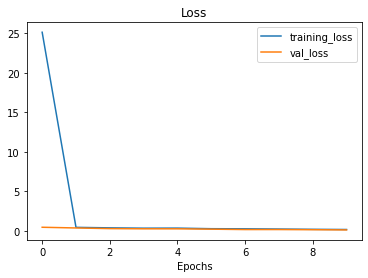

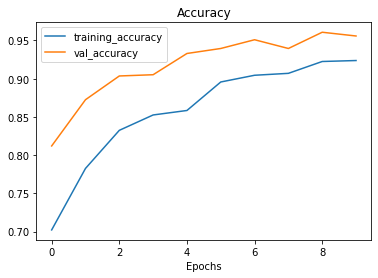

In [40]:
from helper_functions import plot_loss_curves, make_confusion_matrix

plot_loss_curves(history)

**NOTE:** As you can see from the graph the model is overfitting, because of the separation between the lines of train and val loss and accuracy

Lets test the model on pred data (unseen data) before regularization

In [ ]:
model.evaluate(val_data)

20/20 [==============================] - 1s 18ms/step - loss: 0.1570 - accuracy: 0.9395


[0.15697209537029266, 0.9395424723625183]

In [ ]:
model.save("BrainTumor.h5")

In [ ]:
model = tf.keras.models.load_model("BrainTumor.h5")

In [ ]:
model.evaluate(val_data)

20/20 [==============================] - 1s 18ms/step - loss: 0.1570 - accuracy: 0.9395


[0.15697208046913147, 0.9395424723625183]

In [ ]:
from helper_functions import load_and_prep_image

In [ ]:
img = load_and_prep_image("/content/Brain_Tumor_Data/pred/pred0.jpg", img_shape=180)

In [ ]:
pred = model.predict(tf.expand_dims(img, axis = 0))

In [ ]:
np.round(pred)

array([[0.]], dtype=float32)

In [ ]:
list_preds = tf.data.Dataset.list_files(str(data_dir/'pred/*.jpg'),shuffle=True) 


In [ ]:
plt.figure(figsize=(10, 10))
# plt.subplots_adjust(hspace=0.1)
plt.suptitle("Unseen Image Predictions", fontsize=20, c = "w")

img_number=0
for img in list_preds.take(9):

  ax = plt.subplot(3, 3, img_number + 1)
  img_number +=1

  img = load_and_prep_image(img, img_shape = 180, scale=False) # load in target image and turn it into tensor
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  index = np.round(pred_prob[0]).astype('int')
  pred_class = class_names[index][0] # find the predicted class label
  # Plot the image with appropriate annotations
  
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized

  if pred_class == "no":
    plt.title(f"prediction: No Tumor", c = "white")
  else:
    plt.title(f"prediction: With Tumor", c = "white")

  plt.axis(False)
# plt.savefig("Predictions_Custom_Images.jpg")

In [ ]:
model.save("BrainTumor.h5")

In [ ]:
!mkdir tfjs_model

In [ ]:
pip install tensorflowjs

In [ ]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model, "tfjs_model")

In [ ]:
from google.colab import files
files.download('/content/tfjs_model') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('/content/tfjs_model/model.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>